In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import re 
import pandas
from collections import defaultdict
#from smile_generator import *
from rdkit import Chem
from kidanemariam_ezr import *

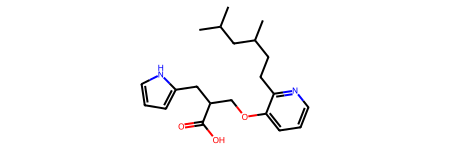

In [48]:
mol_object=Molecule.from_smiles("CC(CC(C)C)CCc1ncccc1OCC(C(O)=O)Cc1[nH]ccc1")
mol_object

In [50]:
classified_m=Molecule.classify_BM_atom(mol_object)
classified_m

{<CH1>: 'linkers',
 <CH2>: 'linkers',
 <CH2>: 'side chain',
 <CH2>: 'side chain',
 <O>: 'linkers',
 <CH3>: 'side chain',
 <CH3>: 'side chain',
 <C>: 'ring',
 <CH1>: 'ring',
 <CH1>: 'ring',
 <CH1>: 'ring',
 <O>: 'side chain',
 <CH1>: 'ring',
 <C>: 'ring',
 <CH1>: 'ring',
 <CH1>: 'side chain',
 <CH3>: 'side chain',
 <CH1>: 'ring',
 <NH1>: 'ring',
 <CH1>: 'side chain',
 <C>: 'ring',
 <OH1>: 'side chain',
 <C>: 'side chain',
 <N>: 'ring',
 <CH2>: 'linkers',
 <CH2>: 'side chain'}

In [14]:


def classify_BM_atoms(mol):
    """
    Classifies atoms in a molecule as side chain, ring, or linker atoms.
    
    """
    # Initialize empty classification dictionary
    classification = {}
    
    # Iterate over atoms in the molecule
    for atom in mol.get_atoms():
        # Get atom index
        atom_index = atom
        
        # Get neighbors of atom
        neighbors = [bond.get_other(atom) for bond in atom.get_bonds()]#?
        
        # Check if atom is in a ring
        in_ring = atom.is_in_ring()
        
        # If atom is in a ring, classify as ring atom
        if in_ring:
            classification[atom_index] = 'ring'
        
        # If atom is not in a ring, check if it has only one neighbor
        elif len(neighbors) == 1:
            # If atom has only one neighbor, classify as linker atom
            classification[atom_index] = 'side chain'
        
        # If atom has more than one neighbor, classify as side chain atom
        else:
            classification[atom_index] = 'linkers'
    while True:
        change=False
        for atom in mol.get_atoms():
            if classification[atom]=="linkers":
                sc_neighbors = [nbor for nbor in atom.get_neighbors() if classification[nbor]=="side chain"]
                if atom.get_degree()-len(sc_neighbors)==1:
                    classification[atom]="side chain"
                    change = True
        if not change:
            break
    mol._classification = classification
    return classification

In [15]:
classify_BM_atoms(mol_object)

{<CH1>: 'ring',
 <CH2>: 'linkers',
 <CH1>: 'ring',
 <CH1>: 'ring',
 <C>: 'ring',
 <CH1>: 'side chain',
 <O>: 'side chain',
 <CH2>: 'side chain',
 <CH1>: 'ring',
 <N>: 'ring',
 <CH2>: 'side chain',
 <NH1>: 'ring',
 <CH1>: 'ring',
 <CH2>: 'side chain',
 <C>: 'ring',
 <OH1>: 'side chain',
 <O>: 'linkers',
 <CH3>: 'side chain',
 <CH1>: 'side chain',
 <CH3>: 'side chain',
 <CH2>: 'linkers',
 <CH1>: 'ring',
 <C>: 'side chain',
 <C>: 'ring',
 <CH1>: 'linkers',
 <CH3>: 'side chain'}

This code loads a molecule from a file, classifies the atoms in the molecule using the classify_BM_atoms function, and then uses the RDKit visualization capabilities to highlight the atoms according to their Bemis-Murcko type. A dictionary is used to map each atom type to a specific color, and the SetProp method is used to set a color property for each atom. Finally, the molecule is drawn to a file with the highlighted atoms.

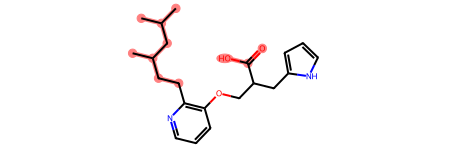

In [16]:
from rdkit import Chem
from rdkit.Chem import Draw

# Load molecule from file
#mol = Chem.MolFromMolFile('molecule.mol')
mol_object.to_rdkit()
# Classify atoms in the molecule
classification = classify_BM_atoms(mol_object)
mol,mapping=mol_object.to_rdkit_with_map()
#--------------------
rdkit_ring_atoms=[mapping[ra] for ra in mol_object.get_atoms() if mol_object._classification[ra]=="side chain"]

rdkit_ring_atoms
mol.__sssAtoms=rdkit_ring_atoms
mol

Task 3

In [17]:
from rdkit import Chem
from copy import deepcopy

def get_BM_scaffold(mol_object):
    """
    Returns the Bemis-Murcko scaffold of a molecule as a new molecule.
    
    """
    # Classify atoms in the molecule
    classification = classify_BM_atoms(mol_object)
    
    # Make a copy of the molecule
    scaffold =deepcopy(mol_object)#.to_rdkit()# Chem.Mol(mol)
    classification = classify_BM_atoms(scaffold)
    mol_object#.to_rdkit()
    # Iterate over atoms in the molecule
    for atom_index, atom_type in classification.items():
        # If atom is a side chain atom, remove it from the scaffold
        if atom_type == 'side chain':
            for bond in atom_index.get_bonds():
                other = bond.get_other(atom_index)
                hc = other.get_hydrogen_count()
                hc += int(bond.get_order())
                other.set_hydrogen_count(hc)
            scaffold.remove_atom(atom_index)
    
    # Update the number of hydrogens on each atom to ensure formal charges remain unchanged???????
    
    
    return scaffold

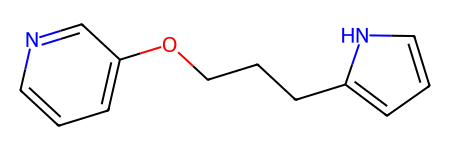

In [18]:
get_BM_scaffold(mol_object)

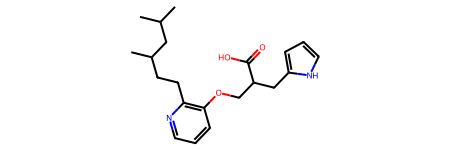

In [19]:
mol_object

task 4

In [20]:
from rdkit import Chem

def get_cyclic_skeleton(scaffold):
    """
    Returns the cyclic skeleton of a Bemis-Murcko scaffold as a new molecule.
    
    """
    # Make a copy of the scaffold
    skeleton = deepcopy(scaffold)
    
    # Iterate over atoms in the scaffold
    for atom in skeleton.get_atoms():
        # Set atom type to carbon
        atom.set_atomic_number(6)
        # set formal charge to 0
        atom.set_formal_charge(0)
        # update hydrogen counts
        #atom.set_hydrogen_count(atom.get_hydrogen_count())--------??
        atom.set_hydrogen_count(4-atom.get_degree())
    
    # Iterate over bonds in the scaffold
    for bond in skeleton.get_bonds():
        # Set bond order to 1
        bond.set_order(1)
       

    
    return skeleton

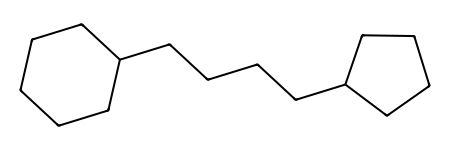

In [21]:
get_cyclic_skeleton(get_BM_scaffold(mol_object))

task 5

This function makes a copy of the cyclic skeleton and iterates over the atoms and bonds in the skeleton, setting the atom degrees to 2 and the bond orders to 1. It then sets the formal charges to 0 and updates the hydrogen counts to ensure that the formal charges remain unchanged. This results in a reduced ring scaffold where all atoms have degree 2 and all bonds have bond order 1, and the lengths of the linkers and the sizes of the rings are minimized

In [22]:
from rdkit import Chem

def get_reduced_ring_scaffold(skeleton):
    """
    Returns the reduced ring scaffold of a cyclic skeleton as a new molecule.
    """
    # Make a copy of the skeleton
    scaffold = deepcopy(skeleton)
    
    # Iterate over atoms in the skeleton
    for atom in scaffold.get_atoms():
        # Set atom degree to 2
        #atom.SetDegree(2)---------------->>><<<
        # set formal charge to 0
        if atom.get_degree()==2:
            nbors = atom.get_neighbors()
            if not nbors[0].get_bond(nbors[1]):
                scaffold.remove_atom(atom)
                scaffold.add_bond(nbors[0],nbors[1],1)
        atom.set_formal_charge(0)
    
    # Iterate over bonds in the skeleton
    for bond in scaffold.get_bonds():
        # Set bond order to 1
        bond.set_order(1)
    
    
    return scaffold

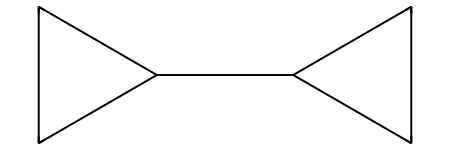

In [23]:
get_reduced_ring_scaffold(get_cyclic_skeleton(get_BM_scaffold(mol_object)))

In [24]:
Molecule.to_smiles(get_reduced_ring_scaffold(get_cyclic_skeleton(get_BM_scaffold(mol_object))))

'C1CC1C1CC1'

### Apply your methods to the molecules in the files 5ht1a.smi, d4.smi, and net.smi. For each of the files, determine the number of different molecules, Bemis-Murcko scaffolds, cyclic skeletons, and reduced ring scaffolds

In [31]:
def file_df(smi):
    with open(smi, "r") as file:
        data = file.readlines()


    smiles = []

    # Iterate through each line and append the first to the list
    for smile in data:
        smiles_ = smile.split(" ")[0]
        smiles.append(smiles_)

    # Create a dataframe from the list of first lines, with index column
    df = pd.DataFrame(smiles, columns=["smiles"], index=range(1, len(smiles)+1))
    return df

    





In [32]:
d4_smiles=file_df('d4.smi')
h5t1a_smiles=file_df('5ht1a.smi')
net_smiles=file_df('net.smi')

In [33]:
d4_smiles

smiles
1      CN1CCN2c3c1cccc3C4C2CCN(C4)CCCC(=O)c5ccc(cc5)F
2                          CCN(CC)C(=S)SSC(=S)N(CC)CC
3                       c1ccc(cc1)OCCCNCCOc2ccc(cc2)O
4                              c1cc2c(cc1Cl)CNC(=N2)N
5            c1ccc(cc1)C(c2ccccc2)(c3ccccc3Cl)n4ccnc4
..                                                ...
79  c1ccc(cc1)N2CNC(=O)C23CCN(CC3)CCCC(=O)c4ccc(cc4)F
80         c1cc(ccc1N2CCN(CC2)CCNCC3CCc4ccc(cc4O3)O)I
81                      Cc1ccc(cc1Cl)OCCNCCCOc2ccccc2
82            Cc1ccc(cc1C)C(=NOC)CCN2CCN(CC2)c3ccccn3
83  COc1ccccc1N2CCN(CC2)CCCCn3cc(nn3)c4ccc(cc4)c5c...

[83 rows x 1 columns]

In [34]:
def process_dataframe(df, column, function,desired_col):
    # Apply the function to the specified column
    result = df[column].apply(function)
    # Create a new column in the dataframe with the result
    df[desired_col] = result
    return df

## 6.1

In [43]:
with_unique_structure=process_dataframe(d4_smiles,'smiles',Molecule.from_smiles,'M-structure')
#with_unique_structure

## 6.2

In [44]:
with_BM_scaffold=process_dataframe(with_unique_structure,'M-structure',get_BM_scaffold,'BM-scaffold')
#with_BM_scaffold

## 6.3

In [45]:
with_cyclic_skeleton=process_dataframe(with_BM_scaffold,'BM-scaffold',get_cyclic_skeleton,'cyclic_skeleton')
#with_cyclic_skeleton

## 6.4

In [42]:
with_reduced_ring_scaffold=process_dataframe(with_cyclic_skeleton,'cyclic_skeleton',get_reduced_ring_scaffold,'reduced_ring_scaffold')
with_reduced_ring_scaffold

smiles  \
1      CN1CCN2c3c1cccc3C4C2CCN(C4)CCCC(=O)c5ccc(cc5)F   
2                          CCN(CC)C(=S)SSC(=S)N(CC)CC   
3                       c1ccc(cc1)OCCCNCCOc2ccc(cc2)O   
4                              c1cc2c(cc1Cl)CNC(=N2)N   
5            c1ccc(cc1)C(c2ccccc2)(c3ccccc3Cl)n4ccnc4   
..                                                ...   
79  c1ccc(cc1)N2CNC(=O)C23CCN(CC3)CCCC(=O)c4ccc(cc4)F   
80         c1cc(ccc1N2CCN(CC2)CCNCC3CCc4ccc(cc4O3)O)I   
81                      Cc1ccc(cc1Cl)OCCNCCCOc2ccccc2   
82            Cc1ccc(cc1C)C(=NOC)CCN2CCN(CC2)c3ccccn3   
83  COc1ccccc1N2CCN(CC2)CCCCn3cc(nn3)c4ccc(cc4)c5c...   

                                          M-structure  \
1   <kidanemariam_mychem_new.Molecule object at 0x...   
2   <kidanemariam_mychem_new.Molecule object at 0x...   
3   <kidanemariam_mychem_new.Molecule object at 0x...   
4   <kidanemariam_mychem_new.Molecule object at 0x...   
5   <kidanemariam_mychem_new.Molecule object at 0x...   
..                                                ...   
79  <kidanemariam_mychem_new.Molecule object at 0x...   
80  <kidanemariam_mychem_new.Molecule object at 0x...   
81  <kidanemariam_mychem_new.Molecule object at 0x...   
82  <kidanemariam_mychem_new.Molecule object at 0x...   
83  <kidanemariam_mychem_new.Molecule object at 0x...   

                                          BM-scaffold  \
1   <kidanemariam_mychem_new.Molecule object at 0x...   
2   <kidanemariam_mychem_new.Molecule object at 0x...   
3   <kidanemariam_mychem_new.Molecule object at 0x...   
4   <kidanemariam_mychem_new.Molecule object at 0x...   
5   <kidanemariam_mychem_new.Molecule object at 0x...   
..                                                ...   
79  <kidanemariam_mychem_new.Molecule object at 0x...   
80  <kidanemariam_mychem_new.Molecule object at 0x...   
81  <kidanemariam_mychem_new.Molecule object at 0x...   
82  <kidanemariam_mychem_new.Molecule object at 0x...   
83  <kidanemariam_mychem_new.Molecule object at 0x...   

                                      cyclic_skeleton  \
1   <kidanemariam_mychem_new.Molecule object at 0x...   
2   <kidanemariam_mychem_new.Molecule object at 0x...   
3   <kidanemariam_mychem_new.Molecule object at 0x...   
4   <kidanemariam_mychem_new.Molecule object at 0x...   
5   <kidanemariam_mychem_new.Molecule object at 0x...   
..                                                ...   
79  <kidanemariam_mychem_new.Molecule object at 0x...   
80  <kidanemariam_mychem_new.Molecule object at 0x...   
81  <kidanemariam_mychem_new.Molecule object at 0x...   
82  <kidanemariam_mychem_new.Molecule object at 0x...   
83  <kidanemariam_mychem_new.Molecule object at 0x...   

                                reduced_ring_scaffold  
1   <kidanemariam_mychem_new.Molecule object at 0x...  
2   <kidanemariam_mychem_new.Molecule object at 0x...  
3   <kidanemariam_mychem_new.Molecule object at 0x...  
4   <kidanemariam_mychem_new.Molecule object at 0x...  
5   <kidanemariam_mychem_new.Molecule object at 0x...  
..                                                ...  
79  <kidanemariam_mychem_new.Molecule object at 0x...  
80  <kidanemariam_mychem_new.Molecule object at 0x...  
81  <kidanemariam_mychem_new.Molecule object at 0x...  
82  <kidanemariam_mychem_new.Molecule object at 0x...  
83  <kidanemariam_mychem_new.Molecule object at 0x...  

[83 rows x 5 columns]